# Titanic - Machine Learning from Disaster


Kaggle link: https://www.kaggle.com/c/titanic

Import all the needed library and init Weights and Biases

In [41]:
import numpy as np

import torch
import torch.nn as nn
torch.manual_seed(0)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import pandas as pd
import seaborn as sns

import wandb

In [42]:
num_epochs = 400
lr = 5e-3
batch_size = 32
momentum = 0

wandb.init(project='titanic', config={
    'num-epochs': num_epochs,
    'learning-rate': lr,
    'batch-size': batch_size,
    'momentum': momentum
})

correct%,▁▆███▇▇▆▆▆▅▅▅▆▅▆▅▆▅▆▇▇▆▆▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_loss,█▄▃▂▂▂▂▂▂▂▂▁▂▁▂▂▁▂▁▂▂▂▁▁▂▂▁▂▁▂▂▂▁▁▁▂▁▁▁▂
validation_loss,█▃▂▂▂▄▁▃▂▂▄▄▂▂▃▁▂▃▂▁▃▂▂▂▁▂▂▄▂▄▁▂▁▃▂▃▁▄▃▂
correct%,0.82836
epoch,399
training_loss,8.20933
validation_loss,3.57178


We first need to read the datasets

In [43]:
titanic_training_data = pd.read_csv('data/train.csv')
titanic_test_data = pd.read_csv('data/test.csv')
titanic_training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Dataframe needs to be cleaned, knowing if some informations are unknown can be very important to determine if someone survived

In [44]:
def clean_titanic(df, train=True):
    # store whether some fields are not given as new feature
    df['ageNan'] = df['Age'].apply(lambda x: pd.isna(x)).astype(bool)
    df['cabinNan'] = df['Cabin'].apply(lambda x: pd.isna(x)).astype(bool)
    df['embarkedNan'] = df['Embarked'].apply(lambda x: pd.isna(x)).astype(bool)

    # create a feature that says whether a person is a child (age < 16) or a senor (age > 60)
    df['isChild'] = df['Age'].apply(lambda x: x < 16).astype(bool)
    df['isSenior'] = df['Age'].apply(lambda x: x > 60).astype(bool)
    
    # extract title (taken from: https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling)
    df['title'] = [i.split(',')[1].split('.')[0].strip() for i in df['Name']]
    df['title'] = df['title'].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['title'] = df['title'].map({'Master': 0, 'Miss': 1, 'Ms': 1 , 'Mme': 1, 'Mlle': 1, 'Mrs': 1, 'Mr': 2, 'Rare': 3})
    
    # family size (taken from: https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling)
    df['famSize'] = df['SibSp'] + df['Parch'] + 1
    df['famSingle'] = df['famSize'].map(lambda x: 1 if x == 1 else 0)
    df['famSmall'] = df['famSize'].map(lambda x: 1 if  x == 2  else 0)
    df['famMed'] = df['famSize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
    df['famLarge'] = df['famSize'].map(lambda s: 1 if s >= 5 else 0)
    
    # one-hot-encoding of categorical fields (sex, class and embarked)
    df = pd.concat([
        df,
        pd.get_dummies(df['Sex'], dtype='bool', prefix='sex_'),
        pd.get_dummies(df['Pclass'], dtype='bool', prefix='pclass_'),
        pd.get_dummies(df['Embarked'], dtype='bool', prefix='embarked_'),
        pd.get_dummies(df['title'], prefix='title_')
    ], axis=1)
    df = df.drop(['PassengerId', 'Name', 'Ticket', 'Sex', 'Pclass', 'Embarked', 'Cabin', 'title'], axis=1)

    if train:
        df = df.drop(['Survived'], axis=1)

    # normalize all numerical features (like Age, SibSp, Parch and Fare)
    df['Fare'] = df['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
    
    numeric_features = ['Age', 'SibSp', 'Parch', 'famSize']   #df.dtypes[(df.dtypes != 'object') & (df.dtypes != 'bool')].index
    df[numeric_features] = df[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))

    # fill rows where Age/Fare is not given with the mean of all persons' ages/fares
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    

    return df

targets = torch.tensor(titanic_training_data["Survived"].values, dtype=torch.float32)
training_data = clean_titanic(titanic_training_data)
print(training_data.head(30))

             Age     SibSp     Parch      Fare  ageNan  cabinNan  embarkedNan  \
0  -5.300051e-01  0.432550 -0.473408  1.981001   False      True        False   
1   5.714304e-01  0.432550 -0.473408  4.266662   False     False        False   
2  -2.546462e-01 -0.474279 -0.473408  2.070022   False      True        False   
3   3.649113e-01  0.432550 -0.473408  3.972177   False     False        False   
4   3.649113e-01 -0.474279 -0.473408  2.085672   False      True        False   
5   2.003921e-16 -0.474279 -0.473408  2.135148    True      True        False   
6   1.672866e+00 -0.474279 -0.473408  3.948596   False     False        False   
7  -1.906799e+00  2.246209  0.767199  3.048088   False      True        False   
8  -1.858065e-01 -0.474279  2.007806  2.409941   False      True        False   
9  -1.080723e+00  0.432550 -0.473408  3.403555   False      True        False   
10 -1.769120e+00  0.432550  0.767199  2.815409   False     False        False   
11  1.948225e+00 -0.474279 -

We then transform the data from numpy (pandas representation) into torch's `Tensor`

In [45]:
training_tensor = torch.tensor(training_data.astype('float').values, dtype=torch.float32)
training_tensor[0:5]

tensor([[-0.5300,  0.4326, -0.4734,  1.9810,  0.0000,  1.0000,  0.0000,  0.0000,
          0.0000,  0.0591,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,
          0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
          1.0000,  0.0000],
        [ 0.5714,  0.4326, -0.4734,  4.2667,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0591,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,
          0.0000,  0.0000],
        [-0.2546, -0.4743, -0.4734,  2.0700,  0.0000,  1.0000,  0.0000,  0.0000,
          0.0000, -0.5607,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,
          0.0000,  0.0000],
        [ 0.3649,  0.4326, -0.4734,  3.9722,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0591,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,
          1.0000,  0.0000

Create a `TensorDataset` to get tuple of data and label

In [46]:
dataset = torch.utils.data.TensorDataset(training_tensor, targets)

We then split between the training and validation set

In [47]:
training_size = int(0.7 * len(dataset))
validation_size = len(dataset) - training_size

# random_split creates subsets
train, val = torch.utils.data.random_split(dataset, [training_size, validation_size], generator=torch.Generator().manual_seed(0))

data_loader_train = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
data_loader_val = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)

Layer initialization using Xavier Uniform on the weight and a constant 0 value on the bias

In [48]:
#TODO Xavier Uniform to the weight and set the bias to 0
def init_first_layer(m):
    torch.nn.init.xavier_normal_(m.weight)
    torch.nn.init.constant_(m.bias, 0)
    return m

Create the LinearModel with one Linear layer and Sigmoid applied to the output

In [49]:
class LinearModel(nn.Module):
    #TODO One linear layer and Sigmoid to the ouput
    def __init__(self, in_dim, out_dim):
        super(LinearModel, self).__init__()
        self.linear = init_first_layer(nn.Linear(in_dim, out_dim))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        pred = self.linear(x)
        return self.sigmoid(pred)

Initialize the network (call it `net`, it would makes things easier later), the loss, the optimizer and write the training loop

Don't forget to check the validation loss and save your model at the end of each epoch!

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


<AxesSubplot:xlabel='epoch', ylabel='correct'>

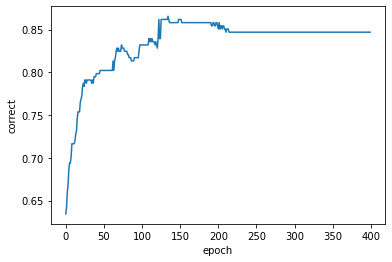

In [50]:
net = LinearModel(training_tensor.shape[1], 1)

# use binary cross entropy loss for binary classification
criterion = nn.BCELoss()
# stochastic gradient decent optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)

wandb.watch(net, log='all', criterion=criterion, log_freq=8,  log_graph=(True))


epoch_losses = []

for epoch in range(num_epochs):
    training_loss = 0

    # iterate over batches
    for (X, y) in data_loader_train:
        y_hat = net(X)
        loss = criterion(y_hat.squeeze(), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

    # VALIDATION LOOP
    counter = 0
    correct = 0
    validation_loss = 0

    with torch.no_grad():
        for (X, y) in data_loader_val:
            y_hat = net(X)
            loss = criterion(y_hat.squeeze(), y)
            validation_loss += loss.item()

            survived = y == 1.0
            survived_hat = y_hat.squeeze() > 0.5

            counter += len(y)
            correct += (survived == survived_hat).sum().item()

    epoch_losses.append({'epoch': epoch, 'loss': validation_loss, 'correct': correct / counter})
    
    wandb.log({'epoch': epoch, 'training_loss': training_loss, 'validation_loss': validation_loss, 'correct%': correct / counter})

    # SAVE THE MODEL
    torch.save(net.state_dict(), f'model/model-e{str(epoch).zfill(4)}.pt')
    
sns.lineplot(data=pd.DataFrame(epoch_losses), x='epoch', y='correct')

This loop computes the prediction on the test dataset and create a submission file

You then just have to click the submit button to get your score, lucky you!

In [51]:
titanic_test_data_cleaned = clean_titanic(titanic_test_data, train=False)
titanic_data_tensor = torch.tensor(titanic_test_data_cleaned.astype('float').values, dtype=torch.float32)

with torch.no_grad():
    net.eval() # enable evaluation mode
    test_pred = torch.LongTensor()

    for i, data in enumerate(titanic_data_tensor):
        output = net(data)
        predicted = torch.ge(output, 0.5)
        test_pred = torch.cat((test_pred, predicted), dim=0)

    out_df = pd.DataFrame(np.c_[titanic_test_data['PassengerId'].values, test_pred.numpy()], columns=['PassengerId', 'Survived'])
    out_df.to_csv('submission.csv', index=False)